## Exploring missing data and implementing KNN imputation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file into a pandas DataFrame
data_dir = "data/" # Define data path
df = pd.read_csv(data_dir + "food_crises_updated.csv") # Read data into DataFrame
print(len(df)) # gives number of total enteries

12324


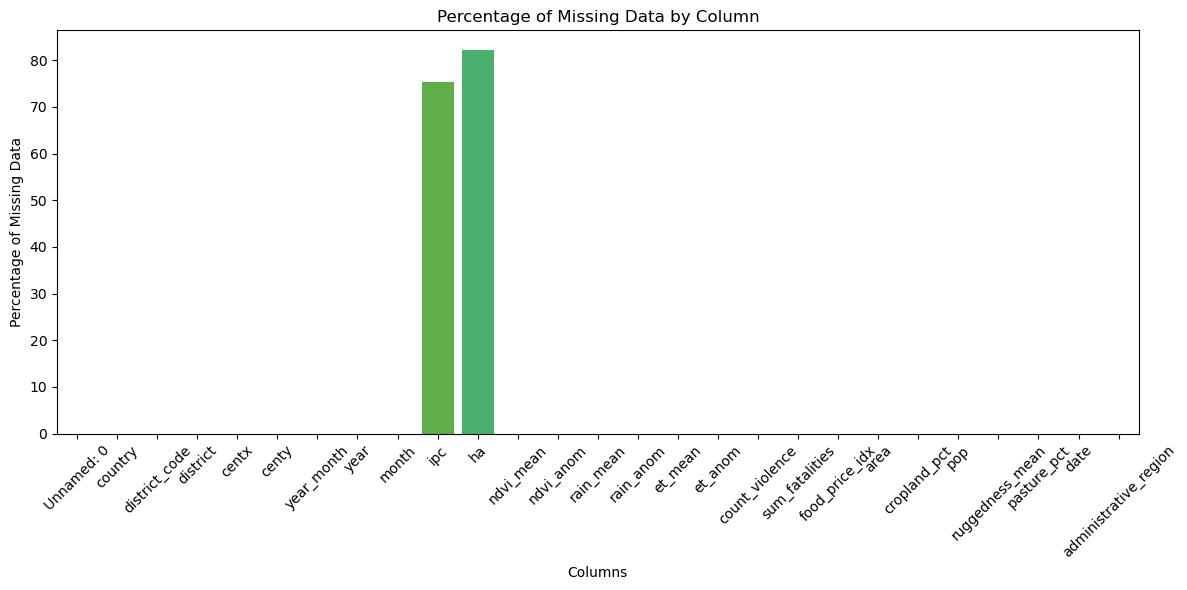

In [2]:
# Calculate the percentage of missing data for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Plot the missing data percentages
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_percentage.index, y=missing_percentage.values)
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Data')
plt.title('Percentage of Missing Data by Column')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The plot above shows that approximately 75% of IPC data is missing and 80% of humanitarian assitance is missing

#### Checking for patterns in the missing data

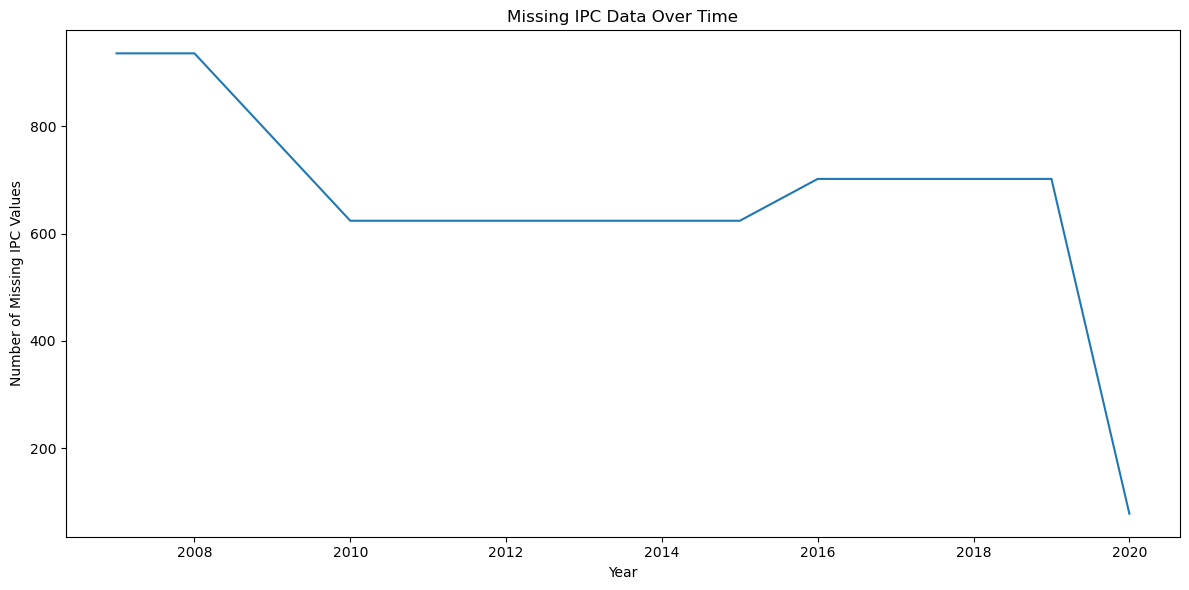

In [3]:
# Check missing data pattern for a specific column (e.g., 'IPC')
ipc_missing_pattern = df['ipc'].isnull().sum()

# Analyze the pattern further, consider time-based analysis
# Example: Check if missing data has a pattern linearly with time
# Assuming a time-related column (e.g., 'date')
# Replace 'date' with the actual time-related column in dataset
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

# Group by year and count missing IPC values for each year
missing_by_year = df.groupby('year')['ipc'].apply(lambda x: x.isnull().sum())

# Plot the missing data pattern over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=missing_by_year.index, y=missing_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Missing IPC Values')
plt.title('Missing IPC Data Over Time')
plt.tight_layout()
plt.show()

The above graph shows missing data for the IPC values over the years. The graph shows a non-linear trend. Given below is the same exploration but for every 3 months, instead of a very so that we get a more granular picture:

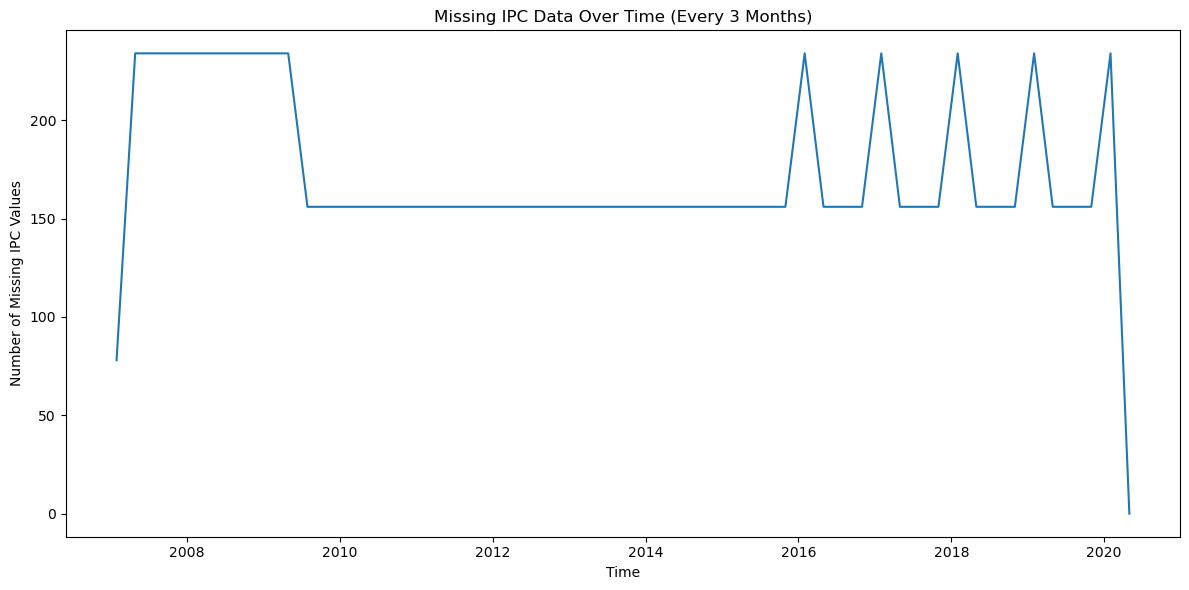

In [4]:
ipc_column = 'ipc'

# Convert 'date' column to datetime
df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Resample data to 3-month intervals and count missing IPC values for each interval
missing_by_3months = df[ipc_column].resample('3M').apply(lambda x: x.isnull().sum())

# Plot the missing data pattern over time for every 3 months
plt.figure(figsize=(12, 6))
sns.lineplot(x=missing_by_3months.index, y=missing_by_3months.values)
plt.xlabel('Time')
plt.ylabel('Number of Missing IPC Values')
plt.title('Missing IPC Data Over Time (Every 3 Months)')
plt.tight_layout()
plt.show()


There seem to be significant differences between the graphs for each year VS over every 3 months. Not sure why this is happening and what is causing it but maybe there are short-Term Fluctuations: Analyzing missing data at a more granular level, such as every 3 months, can reveal short-term fluctuations or anomalies that might not be apparent in a yearly analysis. These fluctuations could be related to specific events, changes in data collection procedures, or other short-term factors affecting data reporting.

If the patterns are significantly different, it's essential to investigate the underlying reasons for these differences. Understanding the context of the data, data collection methodologies, external events, or changes in reporting practices can provide insights into why the missing data patterns vary at different time scales

### Creating a correlation heatmap

Creating a correlation heatmap requires having numerical data, and it's typically used to visualize the correlation between numerical features in a dataset. By doing this, I am trying to find how strongly the presence or absence of one variable (IPC) affects the presence of another.

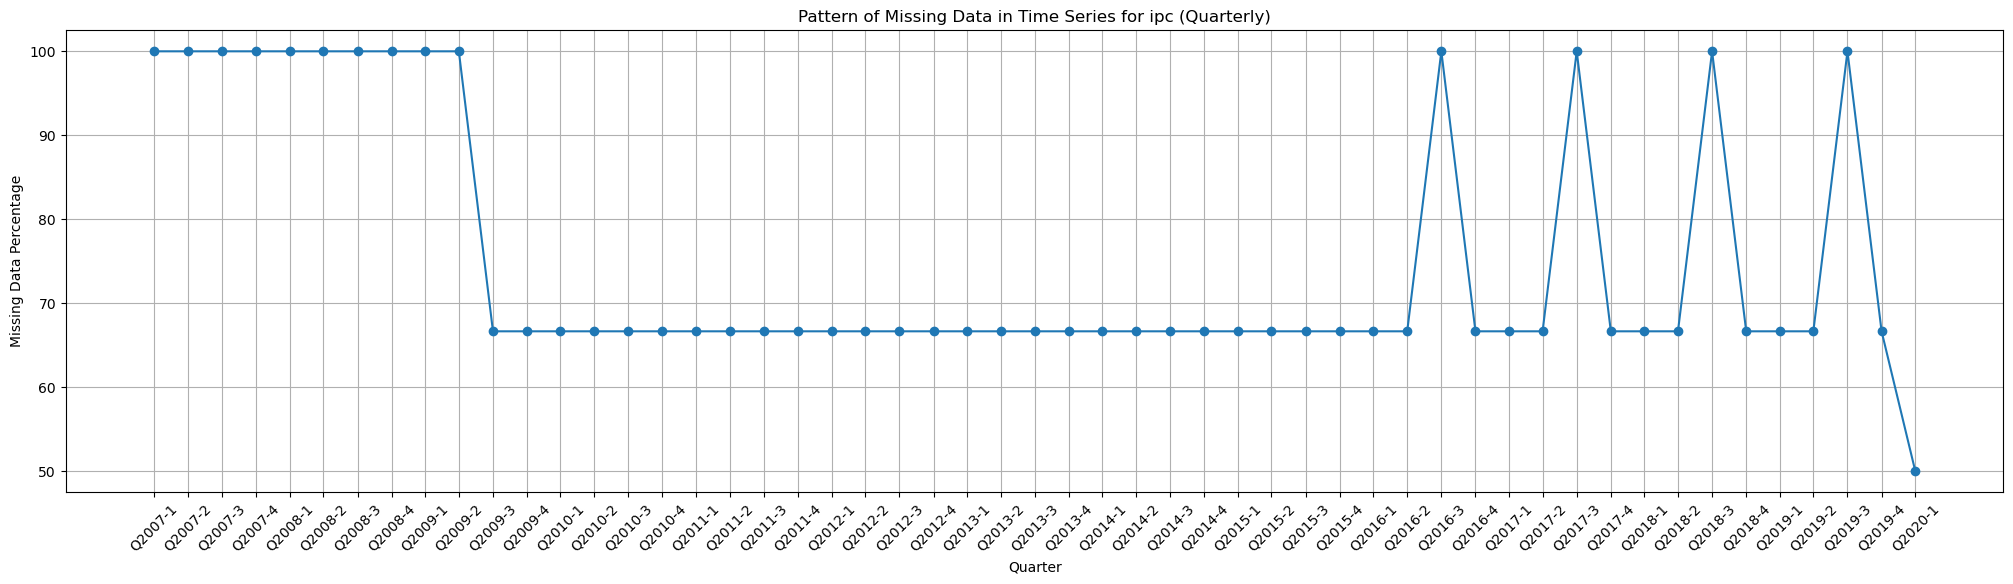

In [5]:
# Calculate the missing data percentage for each quarter
missing_data_percentage = df['ipc'].isnull().astype(int).resample('Q').mean() * 100
quarters = [f'Q{quarter.year}-{quarter.quarter}' for quarter in missing_data_percentage.index]

# Plot the missing data percentage over time (quarterly)
plt.figure(figsize=(25, 6))
plt.plot(missing_data_percentage.index, missing_data_percentage.values, marker='o', linestyle='-')
plt.xticks(missing_data_percentage.index, quarters, rotation=45)  # Set custom x-labels and rotate for readability
plt.xlabel('Quarter')
plt.ylabel('Missing Data Percentage')
plt.title('Pattern of Missing Data in Time Series for ipc (Quarterly)')
plt.grid()
plt.show()

# Inserting a column for quarters based on 'date'
import pandas as pd
# Convert 'year_month' to datetime
df['year_month'] = pd.to_datetime(df['year_month'], format='%Y_%m')

# Extract the quarter from the 'year_month' column
df['quarters'] = df['year_month'].dt.to_period('Q')

In [6]:
# Select columns with numerical data types
numerical_columns = df.select_dtypes(include=['number']).columns

# Print the numerical column names
print("Numerical columns:")
print(numerical_columns)

Numerical columns:
Index(['Unnamed: 0', 'district_code', 'centx', 'centy', 'year', 'month', 'ipc',
       'ha', 'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct'],
      dtype='object')


In [7]:
unique_regions = df['administrative_region'].unique()
print('Unique administrative regions:', unique_regions)

Unique administrative regions: ['Greater Upper Nile' 'Bahr El Ghazal' 'Equatoria']


### Sorting out the unique district codes in Greater Upper Nile, Bahr El Ghazal, Equatoria for further usage in IPC imputation region-wise:

In [8]:
## GREAT UPPER NILE
# Print the first 10 rows of 'district_code' and 'administrative_region' columns
#print(df.loc[:, ['district_code', 'administrative_region']].head(10))

# Initialize a set to store district codes for Greater Upper Nile (ensures uniqueness)
district_codes_nile_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Greater Upper Nile':
        district_codes_nile_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_nile = list(district_codes_nile_set)

# Print the unique district codes in Greater Upper Nile
print('Unique District codes in Greater Upper Nile:', district_codes_in_nile)

Unique District codes in Greater Upper Nile: [130, 134, 135, 136, 137, 138, 139, 140, 142, 143, 144, 146, 147, 148, 149, 150, 151, 74, 104, 109, 111, 114, 115, 116, 118, 119, 120, 121, 122, 123, 124, 127]


In [9]:
## BAHR EL GHAZAL

# Initialize a set to store district codes for Bahr El Ghazal (ensures uniqueness)
district_codes_bahr_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Bahr El Ghazal':
        district_codes_bahr_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_bahr = list(district_codes_bahr_set)

# Print the unique district codes in Bahr El Ghazal
print('Unique District codes in Bahr El Ghazal:', district_codes_in_bahr)


Unique District codes in Bahr El Ghazal: [128, 129, 131, 132, 133, 141, 145, 75, 76, 99, 101, 103, 105, 106, 107, 108, 110, 112, 113, 117, 125, 126]


In [10]:
## EQUATORIA
# Initialize a set to store district codes for Equatoria (ensures uniqueness)
district_codes_eq_set = set()

# Iterate through the DataFrame
for index, row in df.iterrows():
    if row['administrative_region'] == 'Equatoria':
        district_codes_eq_set.add(row['district_code'])

# Convert the set back to a list (to maintain the original list data type)
district_codes_in_eq = list(district_codes_eq_set)

# Print the unique district codes in Equatoria
print('Unique District codes in Equatoria:', district_codes_in_eq)


Unique District codes in Equatoria: [77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, 102]


### Correlation heatmap to check for correlations of food crisis variables with IPC

From all the numerical columns, choosing the following for the correlation heatmap:
'district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
       'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct'

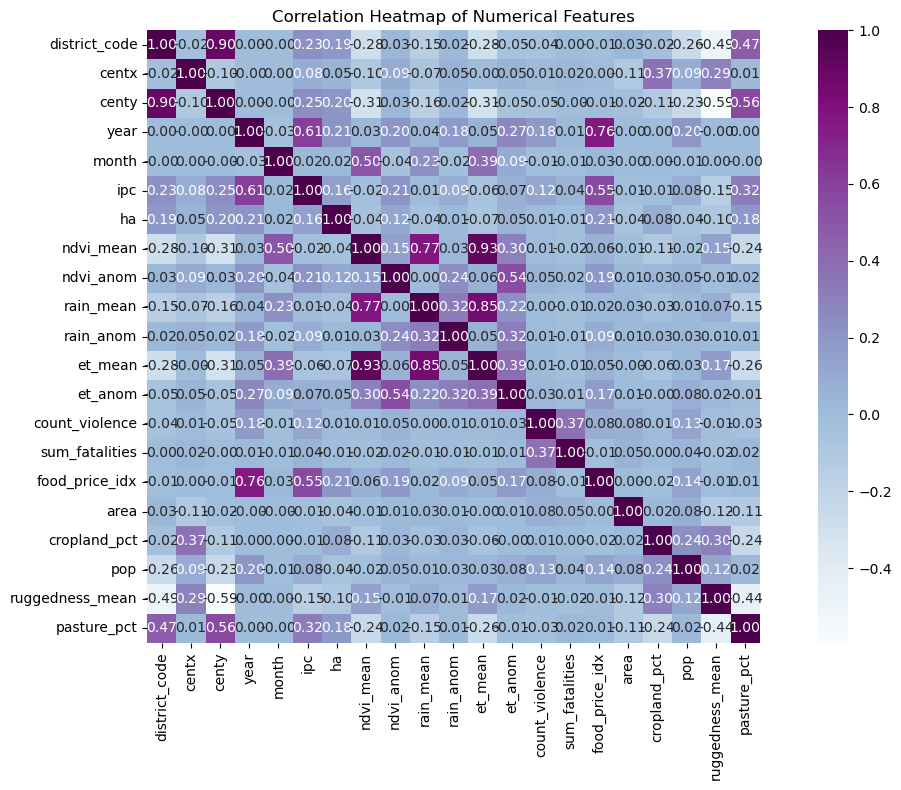

In [11]:
numerical_columns = ['district_code', 'centx', 'centy', 'year', 'month', 'ipc', 'ha',
       'ndvi_mean', 'ndvi_anom', 'rain_mean', 'rain_anom', 'et_mean',
       'et_anom', 'count_violence', 'sum_fatalities', 'food_price_idx', 'area',
       'cropland_pct', 'pop', 'ruggedness_mean', 'pasture_pct']


# Subset the DataFrame to include only numerical columns
numerical_df = df[numerical_columns]

# Calculate the correlation matrix
correlation_matrix = numerical_df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', fmt='.2f', cbar=True, square=True)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

**Correlation of IPC with district-code: 0.23 ->positive but relatively weak correlation**

**Correlation of IPC with year: 0.61 ->strong postive correlation, suggesting a general upward trend or a time-related pattern.**

Correlation of IPC with month: 0.02 ->a very weak positive correlation, little to no discernible monthly pattern in IPC values.

Correlation of IPC with ipc: 1 ->expected

Correlation of IPC with humanitarian aid: 0.16 ->positive but relatively weak correlation

Correlation of IPC with ndvi_mean: -0.02 ->very weak negative correlation, little to no linear relationship between these two variables.

Correlation of IPC with ndvi_anomalies: 0.21 ->positive but relatively weak correlation

Correlation of IPC with rain-mean: 0.01 ->weak positive correlation

Correlation of IPC with rain-anomalies: 0.09 ->positive but relatively weak correlation

Correlation of IPC with count_violence: 0.12 ->positive but relatively weak correlation

Correlation of IPC with sum_fatalities: 0.04 ->positive but relatively weak correlation

**Correlation of IPC with food_price_index: 0.55 ->strong positive correlation, indicates that as the food price index increases, IPC also tends to increase, suggesting a strong relationship between food prices and food security.**

Correlation of IPC with population: 0.08 ->very weak positive correlation, little to no linear relationship between IPC and the population size of the region.

**Correlation of IPC with pasture_pct: 0.32 -> positive but relatively weak correlation. Indictates that the occurence of farmland is somewhat correlated to the ipc scores. However, if there is greater farmland then the ipc scores should be lower - WHY IS THIS HAPPENING?**



### Creating a correlation matrix for Region 1: Greater Upper Nile

In [12]:
## creating a correlation matrix for Region 1: Greater Upper Nile
greater_upper_nile = df[df['administrative_region'] == 'Greater Upper Nile']
#print(greater_upper_nile.head())

# Calculate the correlation matrix for Region 1: Greater Upper Nile
correlation_matrix_nile = greater_upper_nile.corr()

correlation_matrix_nile['ipc']

/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_53310/2473215063.py:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_nile = greater_upper_nile.corr()


Unnamed: 0        -0.064736
district_code     -0.073789
centx             -0.099228
centy             -0.131567
year               0.636702
month              0.036787
ipc                1.000000
ha                 0.014138
ndvi_mean          0.159314
ndvi_anom          0.283401
rain_mean          0.155415
rain_anom          0.145341
et_mean            0.099447
et_anom            0.082940
count_violence     0.100809
sum_fatalities     0.043597
food_price_idx     0.488236
area               0.020064
cropland_pct      -0.085547
pop                0.155297
ruggedness_mean   -0.050628
pasture_pct        0.153195
Name: ipc, dtype: float64

### Creating a correlation matrix for Region 2: Bahr El Ghazal

In [13]:
## creating a correlation matrix for Region 2: Bahr El Ghazal
bahr_el_ghazal = df[df['administrative_region'] == 'Bahr El Ghazal']

# Calculate the correlation matrix for Region 2: Bahr El Ghazal
correlation_matrix_bahr = bahr_el_ghazal.corr()

correlation_matrix_bahr['ipc']

/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_53310/3916778996.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_bahr = bahr_el_ghazal.corr()


Unnamed: 0         0.084946
district_code      0.076627
centx             -0.075184
centy              0.169134
year               0.633606
month              0.036800
ipc                1.000000
ha                 0.180086
ndvi_mean          0.086325
ndvi_anom          0.124932
rain_mean          0.158888
rain_anom          0.129263
et_mean            0.078412
et_anom            0.114314
count_violence     0.091983
sum_fatalities    -0.047433
food_price_idx     0.602395
area              -0.067577
cropland_pct       0.146773
pop                0.234691
ruggedness_mean   -0.109764
pasture_pct        0.123272
Name: ipc, dtype: float64

### Creating a correlation matrix for Region 3: Equatoria

In [14]:
## creating a correlation matrix for Region 3: Equatoria
equatoria = df[df['administrative_region'] == 'Equatoria']

# Calculate the correlation matrix for Region 3: Equatoria
correlation_matrix_equatoria = equatoria.corr()

correlation_matrix_equatoria['ipc']

/var/folders/_f/7jgfw7qx5jn8xl64g_9px9g00000gp/T/ipykernel_53310/907844219.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix_equatoria = equatoria.corr()


Unnamed: 0         0.098357
district_code      0.076613
centx              0.311179
centy             -0.041526
year               0.664034
month             -0.010740
ipc                1.000000
ha                 0.160484
ndvi_mean         -0.148691
ndvi_anom          0.122580
rain_mean         -0.110516
rain_anom          0.009112
et_mean           -0.105088
et_anom            0.038208
count_violence     0.186081
sum_fatalities     0.151902
food_price_idx     0.700130
area               0.073100
cropland_pct       0.213106
pop                0.164045
ruggedness_mean    0.051495
pasture_pct        0.266323
Name: ipc, dtype: float64

## Food_price_index exploration:

**Those metrics worth looking at from the exploration above are district code, year, food-price-index, pasture_pct (due to relatively high correlation with IPC)**
Starting food price index with the following approach:
1. find trend for food price index over the years
2. mine news articles for why it behaves the way it does (goes up linearly, patterns, trends, etc) - sentiment analysis
3. use SLE angles to justify and gives us a direction for further reserach

The FAO Food Price Index is a measure of the monthly change in international prices of a basket of food commodities.

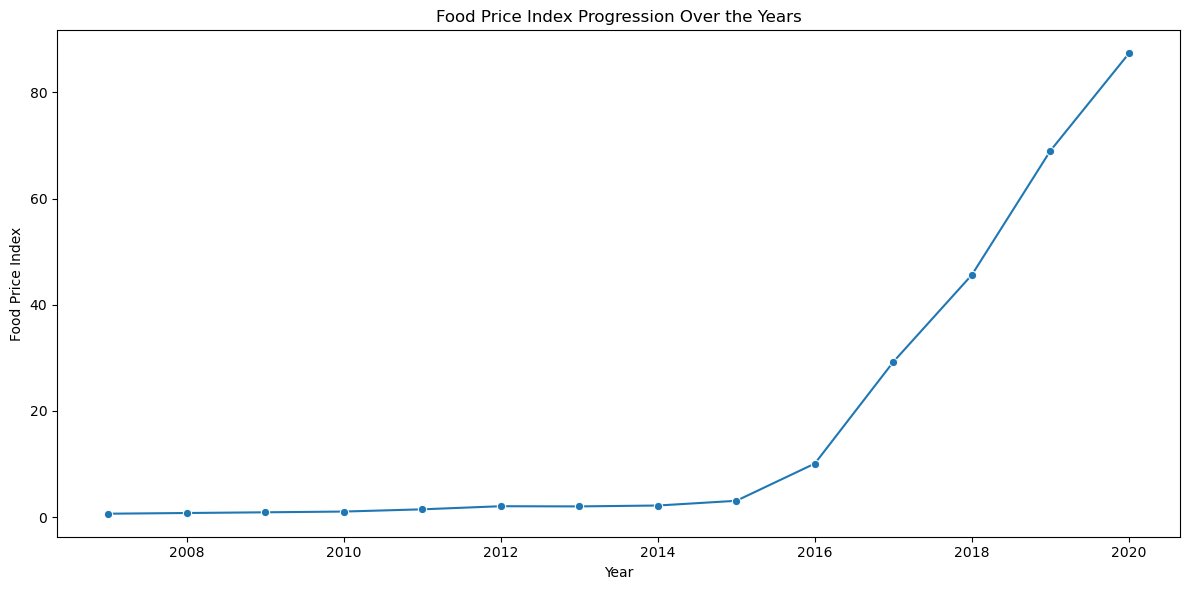

In [15]:
food_price_column = 'food_price_idx'

# Group by year and calculate the mean food price index for each year
food_price_by_year = df.groupby('year')[food_price_column].mean()

# Plot the food price index over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=food_price_by_year.index, y=food_price_by_year.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Food Price Index')
plt.title('Food Price Index Progression Over the Years')
plt.tight_layout()
plt.show()


Look for indicators as to why the food prices have been exponentially escalating since 2015 by mining the news articles, using external news data, and carrying out research:

**1. Cyclical Relationship:**

This correlation suggests a cyclical relationship: economic factors can influence food prices, which in turn affect food security. When food prices are high, households may struggle to afford sufficient food, leading to increased food insecurity. Conversely, during times of economic stability or lower food prices, food security might improve.

**2. Policy and Interventions:**

Recognizing the strong correlation between food price index and food insecurity, policymakers and organizations can design interventions to address both aspects simultaneously. This could include measures to stabilize food prices, improve income levels, provide safety nets for vulnerable populations, or enhance agricultural production to increase food availability and affordability.

### Overall progression of Food price index in all 3 administrative regions

In [16]:
# Group by year and calculate the mean food price index for each year
food_price_by_year_nile = greater_upper_nile.groupby('year')[food_price_column].mean()

#print(food_price_by_year_nile)
"""
# Plot the food price index over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=food_price_by_year_nile.index, y=food_price_by_year_nile.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Food Price Index')
plt.title('Food Price Index Progression Over the Years in Greater Upper Nile')
plt.tight_layout()
plt.show()
"""
# Group by year and calculate the mean food price index for each year
food_price_by_year_bahr = bahr_el_ghazal.groupby('year')[food_price_column].mean()

#print(food_price_by_year_bahr)
"""
# Plot the food price index over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=food_price_by_year_bahr.index, y=food_price_by_year_bahr.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Food Price Index')
plt.title('Food Price Index Progression Over the Years in Bahr El Ghazal')
plt.tight_layout()
plt.show()
"""
# Group by year and calculate the mean food price index for each year
food_price_by_year_equatoria = equatoria.groupby('year')[food_price_column].mean()

#print(food_price_by_year_equatoria)
"""
# Plot the food price index over the years
plt.figure(figsize=(12, 6))
sns.lineplot(x=food_price_by_year_equatoria.index, y=food_price_by_year_equatoria.values, marker='o')
plt.xlabel('Year')
plt.ylabel('Food Price Index')
plt.title('Food Price Index Progression Over the Years in Equatoria')
plt.tight_layout()
plt.show()
"""

"\n# Plot the food price index over the years\nplt.figure(figsize=(12, 6))\nsns.lineplot(x=food_price_by_year_equatoria.index, y=food_price_by_year_equatoria.values, marker='o')\nplt.xlabel('Year')\nplt.ylabel('Food Price Index')\nplt.title('Food Price Index Progression Over the Years in Equatoria')\nplt.tight_layout()\nplt.show()\n"

See Progression of food price indexes in all 3 regions side by side

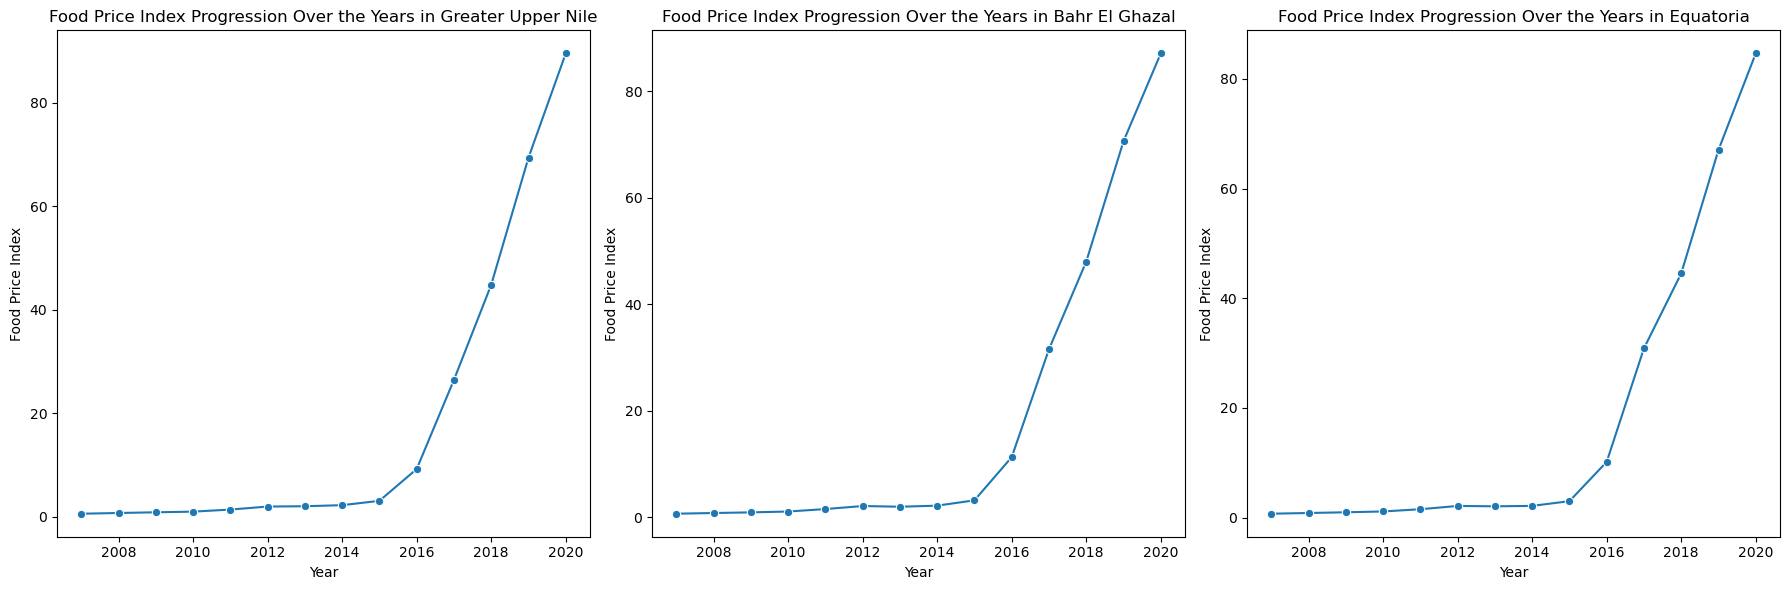

In [17]:
## See Progression of food price indexes in all 3 regions side by side
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for Great Upper Nile
sns.lineplot(ax=axes[0], x=food_price_by_year_nile.index, y=food_price_by_year_nile.values, marker='o')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Food Price Index')
axes[0].set_title('Food Price Index Progression Over the Years in Greater Upper Nile')

# Plot for Bahr El Ghazal
sns.lineplot(ax=axes[1], x=food_price_by_year_bahr.index, y=food_price_by_year_bahr.values, marker='o')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Food Price Index')
axes[1].set_title('Food Price Index Progression Over the Years in Bahr El Ghazal')

# Plot for Equatoria
sns.lineplot(ax=axes[2], x=food_price_by_year_equatoria.index, y=food_price_by_year_equatoria.values, marker='o')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Food Price Index')
axes[2].set_title('Food Price Index Progression Over the Years in Equatoria')

plt.tight_layout()
plt.show()


It can be observed that all 3 regions have a very similar increasing trend in the food price index over the years starting 2015. There are however, subtle difference between the 3 regions. For example, Equatoria has a slightly steeper climb in prices from 2016 to 2017. Although these are subtle difference, they may contribute to getting a better understanding of which regions are more affected or whether they are all the same. This can only be proven by further analysis.

Additionally, these graphs show that our hypothesis that some regions might have been more affected that other in terms of the resulting food price index gets negated. That is, the effect of policies/lack of distribution & aid, etc seems common for all 3 regions, and not in favor of any.

### KNN IMPUTATION TEST: not favourable


In [18]:
import numpy as np
from sklearn.impute import KNNImputer

# Select relevant columns for imputation
selected_features = ['year', 'food_price_idx', 'pasture_pct', 'ipc']

# Prepare features (X) and target (y) for imputation
X = df[selected_features[:-1]]  # Features (excluding IPC)
y = df['ipc']  # Target variable (IPC)

# Initialize the KNN imputer
knn_imputer = KNNImputer(n_neighbors=3)  # You can adjust n_neighbors as needed

# Impute missing IPC values based on available features
imputed_ipc_values = knn_imputer.fit_transform(X)

# Constrain the imputed IPC values to the range [0, 5]
imputed_ipc_values = np.clip(imputed_ipc_values, 0, 5)

# Update the DataFrame with the clipped imputed IPC values
df['ipc'] = imputed_ipc_values

# Check if there are any missing IPC values
print("Are there any missing IPC values?", df['ipc'].isnull().any())

# Print the DataFrame to verify the changes
print(df.head())

sum_stats_knn = df[['ipc']].describe()
sum_stats_knn

Are there any missing IPC values? False
            Unnamed: 0      country  district_code district     centx  \
date                                                                    
2007-01-01           0  South Sudan             74      Bor  32.00486   
2007-02-01           1  South Sudan             74      Bor  32.00486   
2007-03-01           2  South Sudan             74      Bor  32.00486   
2007-04-01           3  South Sudan             74      Bor  32.00486   
2007-05-01           4  South Sudan             74      Bor  32.00486   

               centy year_month  year  month  ipc  ...  count_violence  \
date                                               ...                   
2007-01-01  6.465644 2007-01-01  2007      1  5.0  ...               0   
2007-02-01  6.465644 2007-02-01  2007      2  5.0  ...               0   
2007-03-01  6.465644 2007-03-01  2007      3  5.0  ...               0   
2007-04-01  6.465644 2007-04-01  2007      4  5.0  ...               0   
2007

,ipc
count,12324.0
mean,5.0
std,0.0
min,5.0
25%,5.0
50%,5.0
75%,5.0
max,5.0


Imputed ipc values are almost all 5 because the k-nearest values are very far away. So using the Euclidean distance prior to constraining the values between 1 and 5 gave very big values (like 2007). Therefore KNN imputation is a bad idea.